## <span style="color:green"> Notebook - Geophysical anomalies along a continental geotherm </span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

This notebook...

In [2]:
import pide
import numpy as np
import matplotlib.pyplot as plt

#For building a geotherm.
from pide.geodyn.geotherm import calculate_hasterok2011_geotherm

In [3]:
moho = 38 #km

T, depth, p, idx_LAB = calculate_hasterok2011_geotherm(SHF = 40, T_0 =25.0,max_depth = 250,moho = 38.0)

Now let's plot the geotherm

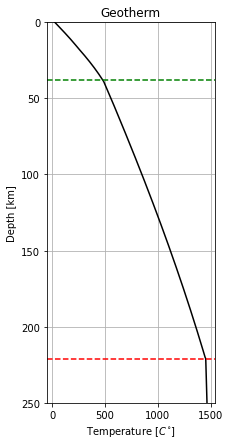

In [4]:
fig = plt.figure(figsize = (3,7))
ax = plt.subplot(111)
ax.plot(T-273.15,depth/1e3,color = 'k')
ax.axhline(moho,linestyle = '--', color = 'g')
ax.axhline(depth[idx_LAB]/1e3,linestyle = '--', color = 'r')
ax.set_ylim(0,250.0)
ax.grid(which = 'both')
ax.set_xlabel(r'Temperature [$C^{\circ}$]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.set_title('Geotherm')
plt.show()


Now, let's calculate the electrical conductivity and seismic velocities that would result form this geotherm. We assume a simple lherzolitic matrix with 100 ppm bulk water content. The below cell will calculate the electrical conductivities.

In [7]:
p_obj = pide.pide()

p_obj.set_temperature(T)
p_obj.set_pressure(p)

p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.25,cpx = 0.1, garnet= 0.05)
p_obj.set_bulk_water(100)
p_obj.set_mantle_water_partitions(opx_ol = 3, cpx_ol = 6, garnet_ol = 0)
p_obj.mantle_water_distribute()
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 2, cpx = 4, gt = 4)
p_obj.set_solid_phs_mix_method(method = 1)
cond = p_obj.calculate_conductivity()

In pide, the seismic velocities can be calculated by simply running ***calculate_seismic_velocities*** method.

In [8]:
v_bulk, v_p, v_s = p_obj.calculate_seismic_velocities()

Now, let's plot them all together... We will plot electrical resistivity (1/electrical conductivity) since it is the general convention in magnetotelluric studies instead of plotting the conductivity. 

Text(0.5, 1.0, 'Seismic Velocities')

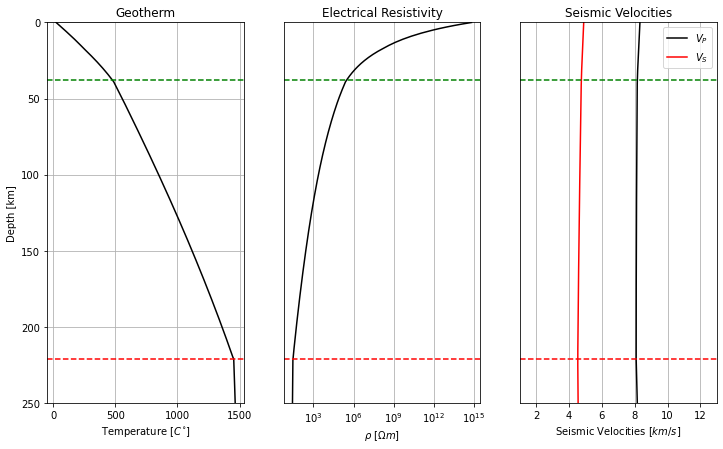

In [18]:
fig = plt.figure(figsize = (12,7))
ax = plt.subplot(131)
ax.plot(T-273.15,depth/1e3,color = 'k')
ax.axhline(moho,linestyle = '--', color = 'g')
ax.axhline(depth[idx_LAB]/1e3,linestyle = '--', color = 'r')
ax.set_ylim(0,250.0)
ax.grid(which = 'both')
ax.set_xlabel(r'Temperature [$C^{\circ}$]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.set_title('Geotherm')

#Plotting the electrical resistivity profile.
ax2 = plt.subplot(132)
ax2.plot(1./cond,depth/1e3,color = 'k')
ax2.axhline(moho,linestyle = '--', color = 'g')
ax2.axhline(depth[idx_LAB]/1e3,linestyle = '--', color = 'r')
ax2.set_ylim(0,250.0)
ax2.set_xscale('log')
ax2.grid(which = 'both')
ax2.set_xlabel(r'$\rho$ [$\Omega m$] ')
ax2.set_yticks([])
ax2.invert_yaxis()
ax2.set_title('Electrical Resistivity')

#plotting the seismic velocities

ax3 = plt.subplot(133)
ax3.plot(v_p,depth/1e3,color = 'k', label = r'$V_P$')
ax3.plot(v_s,depth/1e3,color = 'r', label = r'$V_S$')
ax3.axhline(moho,linestyle = '--', color = 'g')
ax3.axhline(depth[idx_LAB]/1e3,linestyle = '--', color = 'r')
ax3.set_ylim(0,250.0)
ax3.set_xlim(1,13)
ax3.grid(which = 'both')
ax3.set_xlabel(r'Seismic Velocities [$km/s$]')
ax3.set_yticks([])
ax3.invert_yaxis()
ax3.legend()
ax3.set_title('Seismic Velocities')



Now, let's do the same with assuming